In [1]:
import pandas as pd
import numpy as np
import matplotlib as pt
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 20, 8
import plotly.graph_objs as go
import chart_studio.plotly
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler  

In [2]:
df_Vadhvan=pd.read_csv("Vadhvan.csv")

In [3]:
required_data = df_Vadhvan[['Modal_Price','Arrival_Date','Tons']]
required_data.index = required_data['Arrival_Date']
required_data.index=pd.DatetimeIndex(required_data.index)
required_data=required_data.drop("Arrival_Date",axis=1)
required_data['Modal_Price'] = required_data['Modal_Price'].map(lambda x: float(x))
required_data = required_data.fillna(required_data.bfill())
prices=required_data['Modal_Price']
idx = pd.period_range(start=min(df_Vadhvan.Arrival_Date), end=max(df_Vadhvan.Arrival_Date),freq="D")
required_data.index=required_data.index.to_period("D")
required_data=required_data.reindex(idx, method='ffill')

In [4]:
train_data, test_data = required_data[3:int(len(required_data)*0.95)],required_data[int(len(required_data)*0.95):]

In [5]:
train_data=train_data.to_numpy()

In [6]:
scaler=MinMaxScaler()
train_data = train_data.reshape(-1,1)
scaler.fit(train_data)

MinMaxScaler()

In [7]:
train_data = scaler.transform(train_data)

In [8]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 15
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 1))

print(X_train.shape)

(12119, 15, 1)


In [9]:
import keras

In [10]:
from keras.models import Sequential #The simplest model is defined in the Sequential class which is a linear stack of Layers. You can create a Sequential model and define all of the layers in the constructor
from keras.layers import Dense #Dense layer is the regular deeply connected neural network layer. It is most common and frequently used layer
#output = activation(dot(input, kernel) + bias) 
#Dense layer does above operation and gives the output
#kernel-weight matrix
from keras.layers import LSTM
from keras.layers import Dropout

In [11]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_split=.30)

Epoch 1/20
266/266 [==============================] - 24s 90ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 2/20
266/266 [==============================] - 20s 76ms/step - loss: 0.0047 - val_loss: 0.0262
Epoch 3/20
266/266 [==============================] - 27s 100ms/step - loss: 0.0043 - val_loss: 0.0153
Epoch 4/20
266/266 [==============================] - 26s 98ms/step - loss: 0.0038 - val_loss: 0.0077
Epoch 5/20
266/266 [==============================] - 25s 96ms/step - loss: 0.0033 - val_loss: 0.0070
Epoch 6/20
266/266 [==============================] - 32s 121ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 7/20
266/266 [==============================] - 37s 141ms/step - loss: 0.0028 - val_loss: 0.0050
Epoch 8/20
266/266 [==============================] - 33s 122ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 9/20
266/266 [==============================] - 26s 98ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 10/20
266/266 [==============================] - 27s 100ms/step - loss: 

In [12]:
test_data=test_data.to_numpy()

test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = time_steps
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

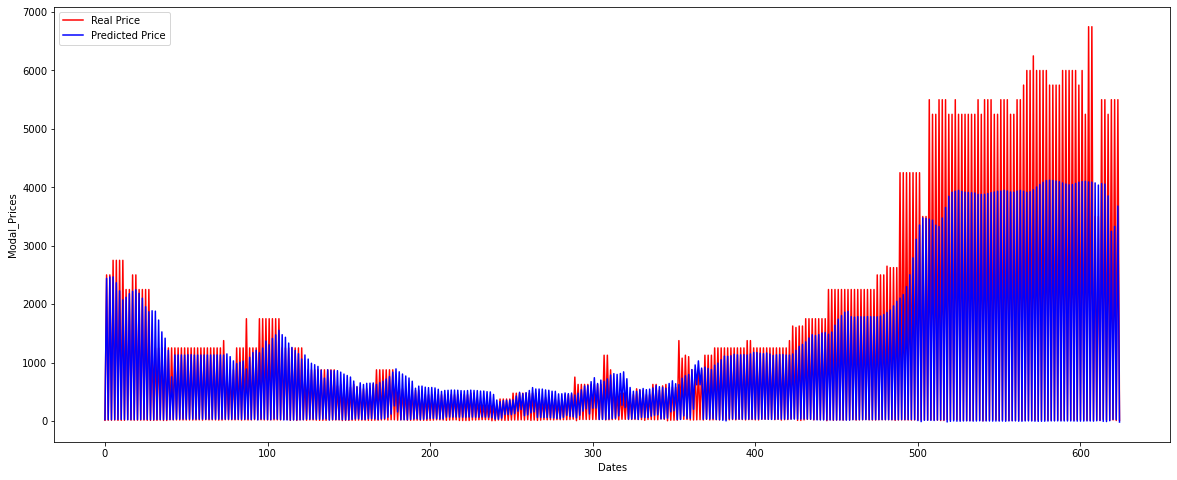

In [13]:
plt.plot(org_y, color = 'red', label = 'Real Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Price')
plt.xlabel('Dates')
plt.ylabel('Modal_Prices')
plt.legend()
plt.show()

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return( np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
MAPE=mean_absolute_percentage_error(org_y,predicted_y)
MAPE

111.98225413422138

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(org_y,predicted_y))
rmse

586.4288033742133

In [16]:
def forecastlstm(required_data,days):
        time_steps = 15
        df=required_data
        required_data=required_data.to_numpy()
        scaler=MinMaxScaler(feature_range = (0, 1))
        required_data = required_data.reshape(-1,1)
        scaler.fit(required_data)
        required_data = scaler.transform(required_data)
        def create_dataset(dataset, look_back):
            dataX, dataY = [], []
            for i in range(len(dataset)-look_back):
                a = dataset[i:(i + look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
            return np.array(dataX), np.array(dataY)

        A = df['Modal_Price'].values
        forecast=time_steps
        for i in range(days+1):
            required_data = A
            required_data = required_data.reshape(-1,1)
            required_data = scaler.transform(required_data)
            Train=required_data[-((time_steps+1)):]
            lstm_list,y=create_dataset(Train, time_steps)
            lstm_list=np.reshape(lstm_list, (lstm_list.shape[0],time_steps, 1))
            predicted_y = model.predict(lstm_list)
            predicted_y = scaler.inverse_transform(predicted_y)
            pred=np.ravel(predicted_y)
            A=np.append(A,pred)
        predicted_list=A[-(days):]
        return predicted_list

In [17]:
Predictions=forecastlstm(required_data,30)

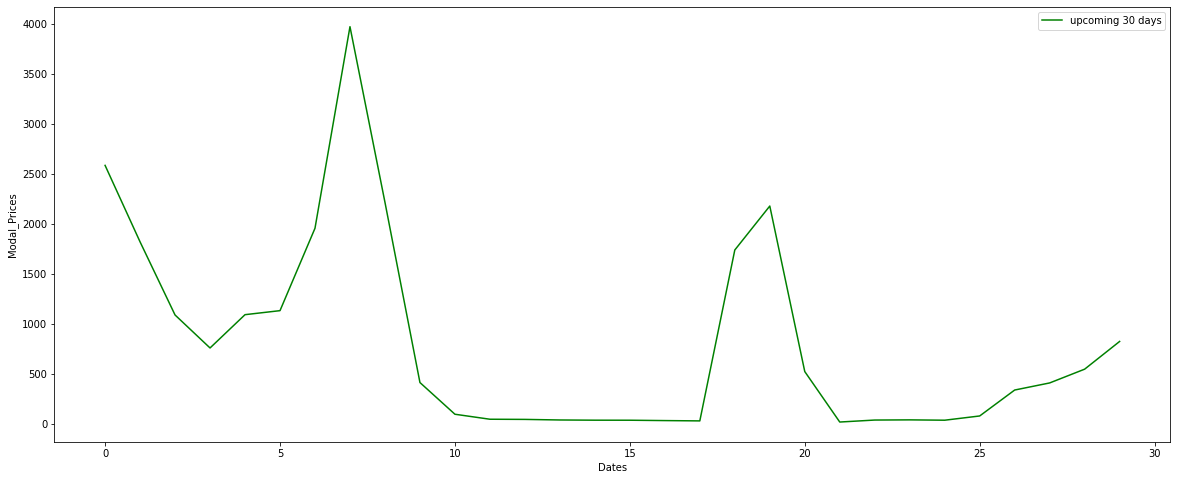

In [19]:
plt.plot(Predictions , color= "green",label="upcoming 30 days")
plt.xlabel('Dates')
plt.ylabel('Modal_Prices')
plt.legend()
plt.show()